In [15]:
import pandas as pd
import numpy as np

In [16]:
df_train = pd.read_csv("/home/abhishek/projects/drugfiles/drugsCom_raw/drugsComTrain_raw.csv")
df_test = pd.read_csv("/home/abhishek/projects/drugfiles/drugsCom_raw/drugsComTest_raw.csv")


In [17]:
len_train = df_train.shape[0]

In [18]:
df_train['sentiment'] = df_train["rating"].apply(lambda x: 2 if x > 7 else (1 if ((x>4)&(x<=7)) else 0))
df_test['sentiment'] = df_test["rating"].apply(lambda x: 2 if x > 7 else (1 if ((x>4)&(x<=7)) else 0))
solution = df_test['sentiment']

In [19]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,2
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,2
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,1
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,2
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,2


In [20]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['sentiment']
feats = ['usefulCount']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        eval_metric='multi_logloss', verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.886063	training's multi_logloss: 0.886063	valid_1's multi_logloss: 0.894688	valid_1's multi_logloss: 0.894688
[200]	training's multi_logloss: 0.885582	training's multi_logloss: 0.885582	valid_1's multi_logloss: 0.894699	valid_1's multi_logloss: 0.894699
Early stopping, best iteration is:
[139]	training's multi_logloss: 0.885816	training's multi_logloss: 0.885816	valid_1's multi_logloss: 0.89466	valid_1's multi_logloss: 0.89466


In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[    0,     0, 13497],
       [    0,     0,  7920],
       [    0,     0, 32349]])

In [22]:
import gc
df_all = pd.concat([df_train,df_test])
del df_train, df_test;
gc.collect()


171

In [23]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['day'] = df_all['date'].dt.day
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month


In [32]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
stemmer = SnowballStemmer('english')
import re

def review_to_words(raw_review):
    
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    
    words = letters_only.lower().split()
    
    stops = set(stopwords.words('english'))
    
    meaningful_words = [w for w in words if not w in stops]
    
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    
    return( ' '.join(stemming_words))
    

In [33]:
%time df_all['review_clean'] = df_all['review'].apply(review_to_words)


CPU times: user 4min 11s, sys: 4 s, total: 4min 15s
Wall time: 4min 16s


In [35]:
from textblob import TextBlob
from tqdm import tqdm
reviews = df_all['review_clean']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment"] = Predict_Sentiment

100%|██████████| 215063/215063 [03:00<00:00, 1192.85it/s]


In [36]:


df_all.head()



,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,day,year,month,review_clean,Predict_Sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2,20,2012,5,side effect take combin bystol mg fish oil,0.000000
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2,27,2010,4,son halfway fourth week intuniv becam concern ...,0.114583
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,1,14,2009,12,use take anoth oral contracept pill cycl happi...,0.105000
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,2,3,2015,11,first time use form birth control glad went pa...,0.300000
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2,27,2016,11,suboxon complet turn life around feel healthie...,0.147037


In [37]:


np.corrcoef(df_all["Predict_Sentiment"], df_all["rating"])



array([[1.        , 0.23246791],
       [0.23246791, 1.        ]])

In [38]:
def review_to_words(raw_review):
    
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    
    words = letters_only.lower().split()
    
    return( ' '.join(words))

In [39]:


%time df_all['review_clean2'] = df_all['review'].apply(review_to_words)



CPU times: user 55.9 s, sys: 663 ms, total: 56.5 s
Wall time: 57 s


In [41]:
from textblob import TextBlob
from tqdm import tqdm
reviews = df_all['review_clean2']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment2"] = Predict_Sentiment


100%|██████████| 215063/215063 [04:05<00:00, 876.68it/s]


In [42]:
np.corrcoef(df_all["Predict_Sentiment2"], df_all["rating"])

array([[1.        , 0.34597794],
       [0.34597794, 1.        ]])

In [43]:


list(df_all['review'].values)[0]



'"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"'

In [53]:
import string

df_all['count_sent']=df_all["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)


df_all['count_word']=df_all["review_clean"].apply(lambda x: len(str(x).split()))
df_all['count_word2']=df_all["review_clean2"].apply(lambda x: len(str(x).split()))


df_all['count_unique_word']=df_all["review_clean"].apply(lambda x: len(set(str(x).split())))
df_all['count_unique_word2']=df_all["review_clean2"].apply(lambda x: len(set(str(x).split())))


df_all['count_letters']=df_all["review_clean"].apply(lambda x: len(str(x)))
df_all['count_letters2']=df_all["review_clean2"].apply(lambda x: len(str(x)))


df_all["count_punctuations"] = df_all["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df_all["count_words_upper"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))


df_all["count_words_title"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))


stops = set(stopwords.words('english'))
df_all["count_stopwords"] = df_all["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))


df_all["mean_word_len"] = df_all["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_all["mean_word_len2"] = df_all["review_clean2"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [54]:
     

df_all['season'] = df_all["month"].apply(lambda x: 1 if ((x>2) & (x<6)) else(2 if (x>5) & (x<9) else (3 if (x>8) & (x<12) else 4)))



In [55]:


df_all.head()



,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,day,year,...,count_unique_word2,count_letters,count_letters2,season,count_words_upper,count_words_title,count_stopwords,mean_word_len,mean_word_len2,count_punctuations
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2,20,2012,...,15,42,74,1,1,6,7,4.375000,3.687500,3
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2,27,2010,...,96,371,714,1,2,13,69,4.723077,4.107143,23
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,1,14,2009,...,88,399,711,4,6,15,59,4.797101,4.313433,34
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,2,3,2015,...,53,225,423,3,4,9,45,4.794872,3.873563,15
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2,27,2016,...,86,380,674,3,7,15,60,5.457627,4.232558,28


In [56]:


df_train = df_all[:len_train]
df_test = df_all[len_train:]



In [57]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['sentiment']
feats = ['usefulCount','day','year','month','Predict_Sentiment','Predict_Sentiment2', 'count_sent',
 'count_word', 'count_word2', 'count_unique_word', 'count_unique_word2', 'count_letters', 'count_letters2', 'count_punctuations',
 'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'mean_word_len2', 'season']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        eval_metric='multi_logloss', verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.776174	training's multi_logloss: 0.776174	valid_1's multi_logloss: 0.801485	valid_1's multi_logloss: 0.801485
[200]	training's multi_logloss: 0.748766	training's multi_logloss: 0.748766	valid_1's multi_logloss: 0.791475	valid_1's multi_logloss: 0.791475
[300]	training's multi_logloss: 0.723774	training's multi_logloss: 0.723774	valid_1's multi_logloss: 0.783208	valid_1's multi_logloss: 0.783208
[400]	training's multi_logloss: 0.701251	training's multi_logloss: 0.701251	valid_1's multi_logloss: 0.776125	valid_1's multi_logloss: 0.776125
[500]	training's multi_logloss: 0.680218	training's multi_logloss: 0.680218	valid_1's multi_logloss: 0.769161	valid_1's multi_logloss: 0.769161
[600]	training's multi_logloss: 0.660418	training's multi_logloss: 0.660418	valid_1's multi_logloss: 0.762157	valid_1's multi_logloss: 0.762157
[700]	training's multi_logloss: 0.641968	training's multi_logloss: 0.6419

[5800]	training's multi_logloss: 0.191243	training's multi_logloss: 0.191243	valid_1's multi_logloss: 0.593381	valid_1's multi_logloss: 0.593381
[5900]	training's multi_logloss: 0.186965	training's multi_logloss: 0.186965	valid_1's multi_logloss: 0.592145	valid_1's multi_logloss: 0.592145
[6000]	training's multi_logloss: 0.182623	training's multi_logloss: 0.182623	valid_1's multi_logloss: 0.590809	valid_1's multi_logloss: 0.590809
[6100]	training's multi_logloss: 0.178345	training's multi_logloss: 0.178345	valid_1's multi_logloss: 0.589467	valid_1's multi_logloss: 0.589467
[6200]	training's multi_logloss: 0.174705	training's multi_logloss: 0.174705	valid_1's multi_logloss: 0.588554	valid_1's multi_logloss: 0.588554
[6300]	training's multi_logloss: 0.171036	training's multi_logloss: 0.171036	valid_1's multi_logloss: 0.587675	valid_1's multi_logloss: 0.587675
[6400]	training's multi_logloss: 0.16738	training's multi_logloss: 0.16738	valid_1's multi_logloss: 0.586419	valid_1's multi_loglo

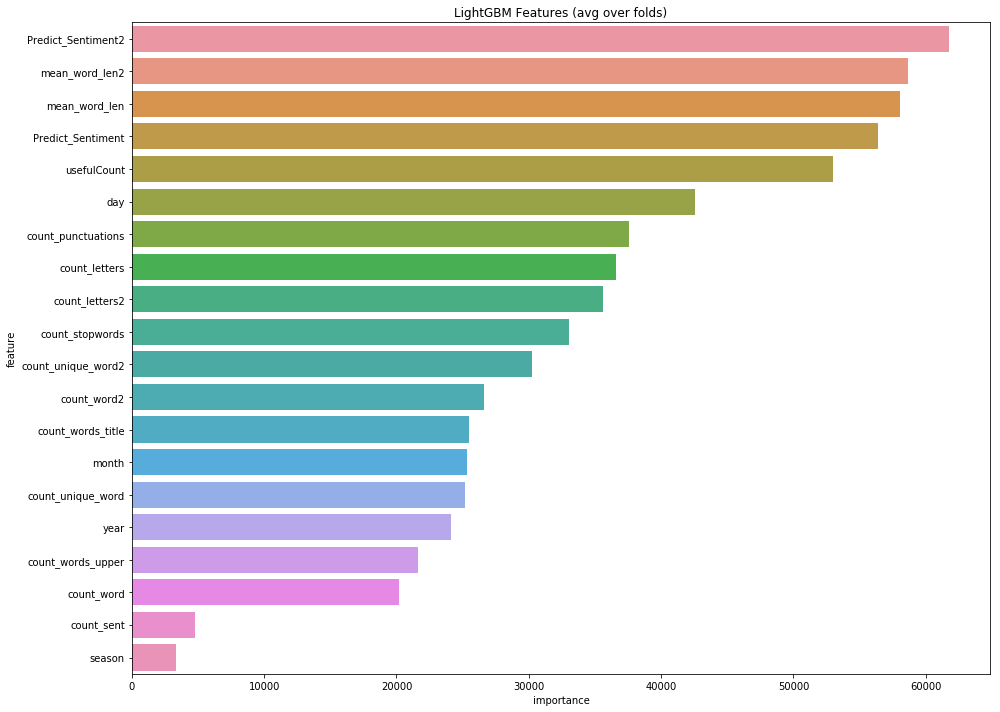

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [61]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[ 9574,   228,  3695],
       [ 1006,  3785,  3129],
       [ 1961,   356, 30032]])

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# 튜토리얼과 다르게 파라메터 값을 수정
# 파라메터 값만 수정해도 캐글 스코어 차이가 많이 남
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(4, 4),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=2,
        ngram_range=(4, 4), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [63]:
pipeline = Pipeline([
    ('vect', vectorizer),
])


In [64]:


df_train.head()



,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,day,year,...,count_unique_word2,count_letters,count_letters2,season,count_words_upper,count_words_title,count_stopwords,mean_word_len,mean_word_len2,count_punctuations
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2,20,2012,...,15,42,74,1,1,6,7,4.375000,3.687500,3
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2,27,2010,...,96,371,714,1,2,13,69,4.723077,4.107143,23
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,1,14,2009,...,88,399,711,4,6,15,59,4.797101,4.313433,34
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,2,3,2015,...,53,225,423,3,4,9,45,4.794872,3.873563,15
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2,27,2016,...,86,380,674,3,7,15,60,5.457627,4.232558,28


In [65]:
%time train_data_features = pipeline.fit_transform(df_train['review_clean'])
%time test_data_features = pipeline.fit_transform(df_test['review_clean'])


CPU times: user 54.9 s, sys: 2.96 s, total: 57.8 s
Wall time: 59.7 s
CPU times: user 22.1 s, sys: 491 ms, total: 22.6 s
Wall time: 22.7 s


In [66]:


train_data_features.shape



(161297, 20000)

In [67]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]


20000


[u'abdomin pain first start',
 u'abdomin pain heavi bleed',
 u'abdomin pain mood swing',
 u'abdomin pain thought would',
 u'abl eat solid food',
 u'abl fall asleep stay',
 u'abl fall asleep without',
 u'abl fall asleep would',
 u'abl fall back asleep',
 u'abl fall back sleep']

In [72]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [73]:
x_train, x_val, y_train, y_val = train_test_split(train_data_features, df_train['sentiment'].values, test_size=0.1, random_state=42)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
161297/161297 [==============================] - 98s 609us/step - loss: 0.8805 - acc: 0.6252
Epoch 2/100
161297/161297 [==============================] - 97s 604us/step - loss: 0.7559 - acc: 0.6800
Epoch 3/100
161297/161297 [==============================] - 97s 604us/step - loss: 0.6828 - acc: 0.7086
Epoch 4/100
161297/161297 [==============================] - 97s 599us/step - loss: 0.6388 - acc: 0.7245
Epoch 5/100
161297/161297 [==============================] - 95s 592us/step - loss: 0.6145 - acc: 0.7323
Epoch 6/100
161297/161297 [==============================] - 96s 595us/step - loss: 0.6010 - acc: 0.7368
Epoch 7/100
161297/161297 [==============================] - 84s 520us/step - loss: 0.5927 - acc: 0.7393
Epoch 8/100
161297/161297 [==============================] - 98s 608us/step - loss: 0.5868 - acc: 0.7410
Epoch 9/100
161297/161297 [=============

161297/161297 [==============================] - 75s 467us/step - loss: 0.5590 - acc: 0.7505
Epoch 73/100
161297/161297 [==============================] - 76s 468us/step - loss: 0.5586 - acc: 0.7505
Epoch 74/100
161297/161297 [==============================] - 76s 469us/step - loss: 0.5591 - acc: 0.7509
Epoch 75/100
161297/161297 [==============================] - 76s 473us/step - loss: 0.5587 - acc: 0.7505
Epoch 76/100
161297/161297 [==============================] - 76s 472us/step - loss: 0.5586 - acc: 0.7503
Epoch 77/100
161297/161297 [==============================] - 76s 470us/step - loss: 0.5590 - acc: 0.7505
Epoch 78/100
161297/161297 [==============================] - 74s 459us/step - loss: 0.5591 - acc: 0.7504
Epoch 79/100
161297/161297 [==============================] - 76s 470us/step - loss: 0.5589 - acc: 0.7507
Epoch 80/100
161297/161297 [==============================] - 79s 490us/step - loss: 0.5587 - acc: 0.7501
Epoch 81/100
161297/161297 [==============================]

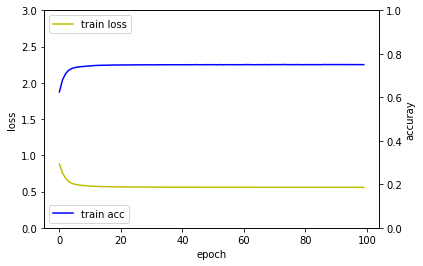

53766/53766 [==============================] - 10s 182us/step
loss_and_metrics : [3.029480980462325, 0.5308187330305251]


In [74]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import to_categorical
import random



y_train = to_categorical(df_train['sentiment'].values, num_classes=3) # one-hot 인코딩

y_test = to_categorical(solution.values, num_classes=3) # one-hot 인코딩


model = Sequential()
model.add(Dense(64, input_dim=20000, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


hist = model.fit(train_data_features,y_train, epochs=100, batch_size=64)


%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 3.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


loss_and_metrics = model.evaluate(test_data_features, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))


In [75]:
confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[ 9574,   228,  3695],
       [ 1006,  3785,  3129],
       [ 1961,   356, 30032]])